# Factor Analysis

This notebook is based on/extending an article posted originally on [DataCamp](https://www.datacamp.com/community/tutorials/introduction-factor-analysis).  The original article is aging, and its example code hasn't been updated to reflect changes in the `factor_analyzer` package used.  The info and discussion from article still a good resource.

The analysis will be focused on the `BFI` dataset; more information on this data can be found [here](https://www.personality-project.org/r/html/bfi.html).

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

%matplotlib inline

data_url = "https://vincentarelbundock.github.io/Rdatasets/csv/psych/bfi.csv"
bfi = pd.read_csv(data_url, index_col=0)

bfi.head()

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,N4,N5,O1,O2,O3,O4,O5,gender,education,age
61617,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0,...,2.0,3.0,3.0,6,3.0,4.0,3.0,1,NaN,16
61618,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,4.0,...,5.0,5.0,4.0,2,4.0,3.0,3.0,2,NaN,18
61620,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,2.0,5.0,...,2.0,3.0,4.0,2,5.0,5.0,2.0,2,NaN,17
61621,4.0,4.0,6.0,5.0,5.0,4.0,4.0,3.0,5.0,5.0,...,4.0,1.0,3.0,3,4.0,3.0,5.0,2,NaN,17
61622,2.0,3.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,2.0,...,4.0,3.0,3.0,3,4.0,3.0,3.0,1,NaN,17


<IPython.core.display.Javascript object>

Our features of interest for this analysis will be the responses to the questions.  These are all the features excluding the subject id and demographic information.

In [3]:
# fmt: off
feat_names = ['A1', 'A2', 'A3', 'A4', 'A5', 
              'C1', 'C2', 'C3', 'C4', 'C5',
              'E1', 'E2', 'E3', 'E4', 'E5', 
              'N1', 'N2', 'N3', 'N4', 'N5', 
              'O1', 'O2', 'O3', 'O4', 'O5']
# fmt: on

X = bfi[feat_names]

print("Top missing value features for X:")
print(X.isnull().mean().sort_values(ascending=False).head())
print(f"\nX shape: {X.shape}")

Top missing value features for X:
N4    0.012857
N5    0.010357
O3    0.010000
A2    0.009643
C4    0.009286
dtype: float64

X shape: (2800, 25)


<IPython.core.display.Javascript object>

Dropping our missing values doesn't impact too much in light of our missing value rate and sample size.  We'll just drop them without too much thought in this demo.

In [4]:
X = X.dropna()
print(f"X shape: {X.shape}")

X shape: (2436, 25)


<IPython.core.display.Javascript object>

If we wanted to make predictions with this data using a linear model (or something similiar) we'd want to check for multicollinearity.  Let's make a heatmap and see if we spot some potentially assumption breaking correlations.

From the heatmap, we see some highly correlated blocks.  The most obvious examples obvious examples are the `N*` features and the `A*` features.

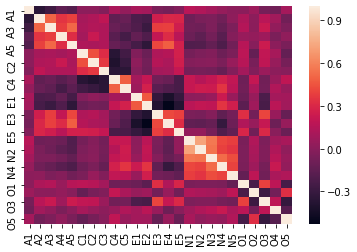

<IPython.core.display.Javascript object>

In [5]:
sns.heatmap(X.corr())
plt.show()

If we wanted to proceed with building a model, we might want to do some dimension reduction first.  Let's use factor analysis through the `factor_analyzer` package.  This package implements the commonly used `varimax` rotation [unlike `sklearn`](https://github.com/scikit-learn/scikit-learn/issues/2688) (`varimax` appears to be [under development still for `sklearn`](https://github.com/scikit-learn/scikit-learn/pull/11064) as of writing this).

Before running a factor analysis, we need to do some "adequacy tests".  If these tests fail, we should not run a factor analysis.

> * Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis.
> * Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [6]:
_, p_value = calculate_bartlett_sphericity(X)
print(f"* Passed Bartlett adequacy test?\n\t{p_value < 0.05} (p = {p_value:.4f})")

_, kmo = calculate_kmo(X)
print(f"* Passed Kaiser-Meyer-Olkin adequacy test?\n\t{kmo >= 0.6} (kmo = {kmo:.4f})")

* Passed Bartlett adequacy test?
	True (p = 0.0000)
* Passed Kaiser-Meyer-Olkin adequacy test?
	True (kmo = 0.8485)


<IPython.core.display.Javascript object>

Cool, we passed our tests. Lets get to factor analyzing.

But how many factors should we choose?  One way to do this is with the [Kaiser Criterion](https://en.wikipedia.org/wiki/Factor_analysis#Older_methods), which is nice due to its simplicity.  We calclulate some eigenvalues and count how many are above 1.  Other [more 'modern' methods](https://en.wikipedia.org/wiki/Factor_analysis#Modern_criteria) are harder to find implementations for.

In [7]:
# This will throw a FutureWarning
# (factor_analyzer version at time of writing this is 0.3.2)
fa = FactorAnalyzer(n_factors=25, rotation="varimax")
_ = fa.fit_transform(X)
ev, _ = fa.get_eigenvalues()

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


<IPython.core.display.Javascript object>

`matplotlib` practice!  Plot the eigenvalues (stored in `ev`)

* [ ] your x axis should be the range [1, # of eigenvalues]
* [ ] your y axis should be the eigenvalue
* [ ] plot a horizontal line at `y=1`
  * [ ] make the line dashed
  * [ ] make the line black
* [ ] for eigenvalues > 1, make the scatter marker a different color
* [ ] give the plot meaningful axis labels and a title

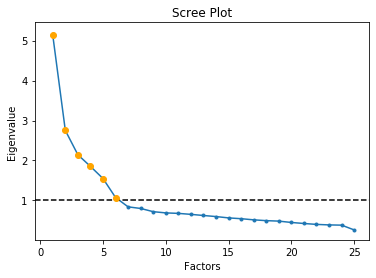

<IPython.core.display.Javascript object>

From our candidate 25 factors, 6 meet the cutoff value of 1.  The 6th is pretty close to our cutoff, but we'll keep it in the set until it's proven not to be useful.

In [9]:
# This will throw a FutureWarning
# (factor_analyzer version at time of writing this is 0.3.2)
fa = FactorAnalyzer(n_factors=6, rotation="varimax")
X_transformed = fa.fit_transform(X)

print(X.shape)
print(X_transformed.shape)

(2436, 25)
(2436, 6)


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


<IPython.core.display.Javascript object>

We successfully trimmed down our feature set to 6... so what?  We could do that with PCA or a lot of other methods. 

Let's look at the factor `loadings_` to see how the original features map to our reduced factors.  We'll use some `pandas` styling to highlight the magnitude of each feature's contribution to the factor (note that this is the *magnitude* aka absolute value).

In [23]:
# Use the loadings_ attribute to build a dataframe 
# Make the dataframe row names the orignal feature names


# Display the loadings with each cell colored by the value

Factor loadings values


,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5
A1,0.0952197,0.0407832,0.0487339,0.530987,0.113057,0.161216
A2,0.0331313,0.235538,0.133714,0.661141,0.0637338,0.00624354
A3,0.00962088,0.343008,0.121353,0.605933,0.0339903,0.160106
A4,0.0815176,0.219717,0.23514,0.404594,0.125338,0.0863557
A5,0.149616,0.414458,0.106382,0.469698,0.0309766,0.236519
C1,0.0043584,0.0772478,0.554582,0.0075107,0.190124,0.095035
C2,0.0683301,0.0383704,0.674545,0.057055,0.0875926,0.152775
C3,0.0399937,0.0318673,0.551164,0.101282,0.0113381,0.00899628
C4,0.216283,0.0662408,0.638475,0.102617,0.143846,0.318359
C5,0.284187,0.180812,0.544838,0.0599548,0.0258371,0.132423


<IPython.core.display.Javascript object>

Our 6th factor isn't adding too much since our first 5 are covering pretty much all the questions.  This factor also doesn't have the benefit of being interpretable like the others.  Recall, it was also borderline with our eigenvalue > 1 rule-of-thumb; let's drop it and move on.

<IPython.core.display.Javascript object>

From our factor analysis we reduced our dimensions and still kept a high level of intpretability in the terms of this dataset.  We can look at another correlation heatmap to see if our data is now green lit for a model that assumes no multicollinearity.

Let's also quickly throw `PCA` at our data to contrast the 2 methods.

From our output we see that unlike factor analysis, the loadings don't offer an easy interpretation.

In [13]:
def pca_loadings(pca):
    return pca.components_.T * np.sqrt(pca.explained_variance_)

<IPython.core.display.Javascript object>

In [21]:
# Perform pca with 5 components and create the same output as for FA
pca = 

loadings = pca_loadings(pca)

Component loadings absolute values (colored by magnitude)


,component_0,component_1,component_2,component_3,component_4
A1,0.320986,0.0776793,0.123023,0.0399037,0.833982
A2,0.473788,0.44001,0.0806145,0.17154,0.478977
A3,0.612865,0.531165,0.169237,0.193592,0.509389
A4,0.626936,0.367257,0.03796,0.605854,0.403814
A5,0.6936,0.384958,0.238786,0.122971,0.367467
C1,0.380892,0.209483,0.639641,0.061886,0.0699562
C2,0.372395,0.315725,0.761587,0.315853,0.0270765
C3,0.393212,0.135573,0.604468,0.389323,0.0841568
C4,0.67441,0.0454004,0.742128,0.173806,0.156279
C5,0.909405,0.0925091,0.702058,0.511997,0.370559


<IPython.core.display.Javascript object>

Let's also throw ICA in the mix.

In [22]:
ica = FastICA(n_components=5)
nba_ics = ica.fit_transform(X)

loadings = pd.DataFrame(ica.mixing_)
loadings.index = X.columns
loadings.columns = [f"ind_component_{i}" for i in range(loadings.shape[1])]

# # Sort by absolute value of column
# sort_order = loadings.abs().sort_values("ind_component_0", ascending=False).index
# loadings = loadings.reindex(sort_order)

print("Component loadings absolute values (colored by magnitude)")
loadings.abs().style.background_gradient(axis=None)

Component loadings absolute values (colored by magnitude)


,ind_component_0,ind_component_1,ind_component_2,ind_component_3,ind_component_4
A1,17.5673,19.2626,13.7385,32.31,9.03972
A2,7.9795,35.2333,11.715,12.9868,7.45143
A3,7.32655,42.1476,15.6606,12.797,12.5622
A4,7.58593,41.5472,23.5973,15.0961,3.48014
A5,5.52193,34.8437,21.7356,7.01478,16.4083
C1,14.2114,17.8649,10.6824,15.8712,24.3023
C2,8.80875,26.9211,9.98521,12.4106,34.3757
C3,1.05298,20.1419,15.9276,10.2198,30.5344
C4,12.3959,14.4035,29.928,19.4647,30.8142
C5,3.84731,20.0288,43.5375,25.2146,35.5167


<IPython.core.display.Javascript object>